In [11]:
import numpy as np
import matplotlib.pyplot as plt
import dmol
from dmol import color_cycle

In [12]:
# From https://gist.github.com/Susensio/61f4fee01150caaac1e10fc5f005eb75

from functools import lru_cache, wraps


def np_cache(*args, **kwargs):
    """LRU cache implementation for functions whose FIRST parameter is a numpy array
    >>> array = np.array([[1, 2, 3], [4, 5, 6]])
    >>> @np_cache(maxsize=256)
    ... def multiply(array, factor):
    ...     print("Calculating...")
    ...     return factor*array
    >>> multiply(array, 2)
    Calculating...
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply(array, 2)
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply.cache_info()
    CacheInfo(hits=1, misses=1, maxsize=256, currsize=1)

    """

    def decorator(function):
        @wraps(function)
        def wrapper(np_array, *args, **kwargs):
            hashable_array = array_to_tuple(np_array)
            return cached_wrapper(hashable_array, *args, **kwargs)

        @lru_cache(*args, **kwargs)
        def cached_wrapper(hashable_array, *args, **kwargs):
            array = np.array(hashable_array)
            return function(array, *args, **kwargs)

        def array_to_tuple(np_array):
            """Iterates recursivelly."""
            try:
                return tuple(array_to_tuple(_) for _ in np_array)
            except TypeError:
                return np_array

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear

        return wrapper

    return decorator

In [13]:
# load image and drop alpha channel
W = 32
try:
    func_vals = plt.imread("quadimg.png")[..., :3]
except FileNotFoundError as e:
    # maybe on google colab
    import urllib.request

    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/whitead/dmol-book/main/dl/quadimg.png",
        "quadimg.png",
    )
    func_vals = plt.imread("quadimg.png")[..., :3]
# we pad it with zeros to show boundary
func_vals = np.pad(
    func_vals, ((1, 1), (1, 1), (0, 0)), mode="constant", constant_values=0.2
)


def pix_func(x):
    # clip & squeeze & round to account for transformed values
    xclip = np.squeeze(np.clip(np.round(x), -W // 2 - 1, W // 2)).astype(int)
    # points are centered, fix that
    xclip += [W // 2, W // 2, 0]
    # add 1 to account for padding
    return func_vals[xclip[..., 0] + 1, xclip[..., 1] + 1]

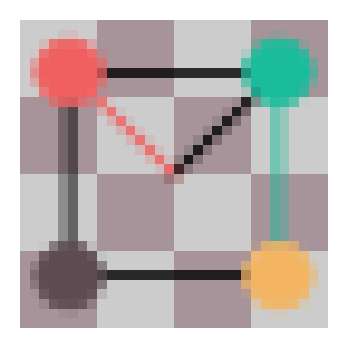

In [14]:
def plot_func(f, ax=None):
    if ax is None:
        plt.figure(figsize=(2, 2))
        ax = plt.gca()
    gridx, gridy = np.meshgrid(
        np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing="ij"
    )
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack(
        (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))
    ).T
    ax.imshow(f(batched_idx).reshape(W, W, 3), origin="upper")
    ax.axis("off")


plot_func(pix_func)


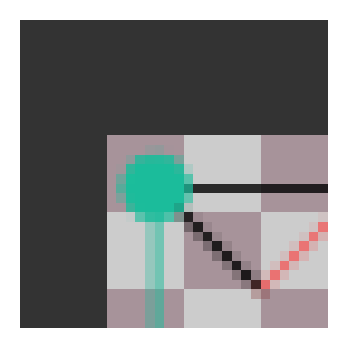

In [15]:
def make_h(rot, mirror):
    """Make h subgroup element"""
    m = np.eye(3)
    if mirror:
        m = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]])
    r = np.array(
        [[np.cos(rot), -np.sin(rot), 0], [np.sin(rot), np.cos(rot), 0], [0, 0, 1]]
    )
    return r @ m


def make_n(dx, dy):
    """Make normal subgroup element"""
    return np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]])


def g_func_trans(g, f):
    """compute g-function transform"""

    @np_cache(maxsize=W**3)
    def fxn(x, g=g, f=f):
        ginv = np.linalg.inv(g)
        return f(ginv.reshape(1, 3, 3) @ x.reshape(-1, 3, 1))

    return fxn


g = make_h(np.pi, 1) @ make_n(12, -8)
tfunc = g_func_trans(g, pix_func)
plot_func(tfunc)

In [16]:
# enumerate stabilizer subgroup (rotation/mirrors)
stabilizer = []
for i in range(4):
    for j in range(2):
        stabilizer.append(make_h(i * np.pi / 2, j))


def lift(f):
    """lift f into group"""

    # create new function from original
    # that is f(gx_0)
    @np_cache(maxsize=W**3)
    def fxn(g, f=f):
        return f(g @ np.array([0, 0, 1]))

    return fxn


def project(f):
    """create projected function over space"""

    @np_cache(maxsize=W**3)
    def fxn(x, f=f):
        # x may be batched so we have to allow it to be N x 3
        x = np.array(x).reshape((-1, 3))
        out = np.zeros((x.shape[0], 3))
        for i, xi in enumerate(x):
            # find coset gH
            g = make_n(xi[0], xi[1])
            # loop over coset
            for h in stabilizer:
                ghi = g @ h
                out[i] += f(ghi)
            out[i] /= len(stabilizer)
        return out

    return fxn


# try them out
print("lifted", lift(pix_func)(g))
print("projected", project(lift(pix_func))([12, -8, 0]))

lifted [0.93333334 0.7176471  0.43137255]
projected [[0.72941178 0.71764708 0.72156864]]


In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

kernel_width = 5  # must be odd
# make some random values for kernel (untrained)
# kernel is group elements x 3 x 3. The group elements are structured (for simplicity) as a N x 5 x 5
# the 3 x 3 part is because we have 3 color channels coming in and 3 going out.
kernel = np.random.uniform(
    -0.5, 0.5, size=(len(stabilizer), kernel_width, kernel_width, 3, 3)
)


def conv(f, p=kernel):
    @np_cache(maxsize=W**4)
    def fxn(u):
        # It is possible to do this without inner for
        # loops over convolution (use a standard conv),
        # but we do this for simplicity.
        result = 0
        for hi, h in enumerate(stabilizer):
            for nix in range(-kernel_width // 2, kernel_width // 2 + 1):
                for niy in range(-kernel_width // 2, kernel_width // 2 + 1):
                    result += (
                        f(u @ make_n(-nix, -niy) @ np.linalg.inv(h))
                        @ kernel[hi, nix + kernel_width // 2, niy + kernel_width // 2]
                    )
        return sigmoid(result)

    return fxn


# compute convolution
cout = conv(lift(pix_func))
# try it out an a group element
cout(g)

array([1.05730277e-03, 6.78471822e-07, 8.35992302e-04])

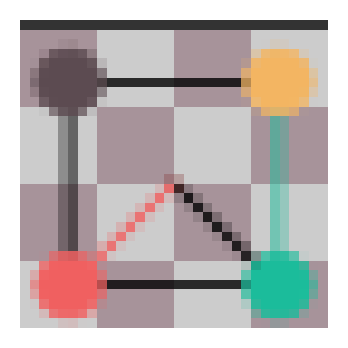

In [18]:
def plot_coset(h, f, ax):
    """plot a function over group elements on cosets given representative g"""
    gridx, gridy = np.meshgrid(
        np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing="ij"
    )
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack(
        (gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))
    ).T
    values = np.zeros((W**2, 3))
    for i, bi in enumerate(batched_idx):
        values[i] = f(h @ make_n(bi[0], bi[1]))
    ax.imshow(values.reshape(W, W, 3), origin="upper")
    ax.axis("off")


# try it with mirror
plt.figure(figsize=(2, 2))
plot_coset(make_h(0, 1), lift(pix_func), ax=plt.gca())

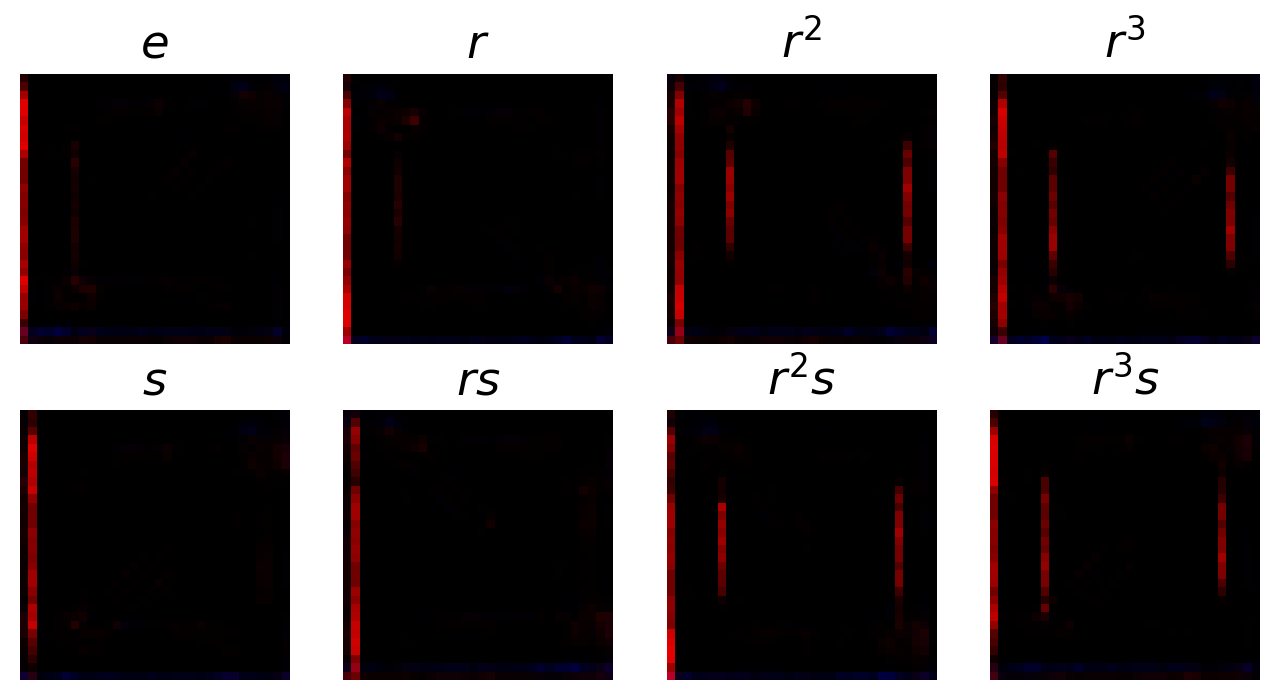

In [19]:
stabilizer_names = ["$e$", "$r$", "$r^2$", "$r^3$", "$s$", "$rs$", "$r^2s$", "$r^3s$"]
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
axs = axs.flatten()
for i, (n, h) in enumerate(zip(stabilizer_names, stabilizer)):
    ax = axs[i]
    plot_coset(h, cout, ax)
    ax.set_title(n)

In [ ]:
fig, axs = plt.subplots(1, 3, squeeze=True)
plot_func(project(cout), ax=axs[0])
axs[0].set_title(r"$\psi\left[f(g)\right]$")

# make a transformation for visualization purposes
g = make_h(np.pi, 0) @ make_n(-10, 16)
tfunc = g_func_trans(g, project(cout))
plot_func(tfunc, ax=axs[1])
axs[1].set_title(r"$\mathbb{T}\psi\left[f(g)\right]$")

tcout = project(conv(lift(g_func_trans(g, pix_func))))

plot_func(tcout, ax=axs[2])
axs[2].set_title(r"$\psi\left[\mathbb{T}f(g)\right]$")
plt.show()